In [1]:
from models.training import GMFTrainer
from models.base_model import GMF
from evaluation.evaluator import Evaluator
import numpy as np
import pandas as pd
import torch

In [2]:
sessions_train_df = pd.read_json('data_files/train_sessions.jsonl', lines=True)
tracks_df = pd.read_json('data_files/tracks.jsonl', lines=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = torch.utils.data.TensorDataset(
    torch.LongTensor(sessions_train_df['user_id'].values).to(device),
    torch.LongTensor(sessions_train_df['track_id'].values).to(device),
    torch.FloatTensor(sessions_train_df['score'].values).to(device)
)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=128,
    shuffle=True
)

unique_users_count = sessions_train_df['user_id'].nunique()
unique_tracks_count = len(tracks_df)

In [3]:
gmf = GMF(unique_users_count + 1, unique_tracks_count + 1, 32)

In [4]:
trainer = GMFTrainer(gmf, train_loader, device)
trainer.train_with_weight_decay(
    epochs=10,
    learning_rate=0.01,
    weight_decay=0.15
)

Epoch 1/10 - Average Loss: 1.6218
Epoch 2/10 - Average Loss: 0.8284
Epoch 3/10 - Average Loss: 0.8294
Epoch 4/10 - Average Loss: 0.8295
Epoch 5/10 - Average Loss: 0.8305
Epoch 6/10 - Average Loss: 0.8289
Epoch 7/10 - Average Loss: 0.8277
Epoch 8/10 - Average Loss: 0.8293
Epoch 9/10 - Average Loss: 0.8293
Epoch 10/10 - Average Loss: 0.8295


In [5]:
print("User embeddings norm:", torch.norm(gmf.user_embedding.weight[0], dim=0))
print("Item embeddings norm:", torch.norm(gmf.item_embedding.weight[0], dim=0))
print("User embeddings vector:", torch.norm(gmf.user_embedding.weight, dim=0))
print("Item embeddings vector:", torch.norm(gmf.item_embedding.weight, dim=0))

User embeddings norm: tensor(1.0195, grad_fn=<LinalgVectorNormBackward0>)
Item embeddings norm: tensor(0.9194, grad_fn=<LinalgVectorNormBackward0>)
User embeddings vector: tensor([ 9.6175,  9.0169,  8.9281,  9.4453,  8.9161,  9.5582,  8.9908,  9.6063,
         9.2014, 10.6382,  9.0275,  9.1671,  9.4143, 10.6382, 10.6382,  8.9839,
         9.1427,  8.8381,  9.4866,  8.8566,  9.2715, 10.6205,  9.3786, 10.6382,
        10.6245,  9.0062,  9.0170,  9.6433,  8.9824,  8.9549,  9.5014, 10.6382],
       grad_fn=<LinalgVectorNormBackward0>)
Item embeddings vector: tensor([18.6116, 17.3119, 17.1187, 18.0951, 17.0928, 18.6487, 17.0557, 18.5039,
        17.6125, 20.1821, 17.3368, 17.4793, 18.3002, 20.1821, 20.1821, 17.2941,
        17.6503, 17.0724, 18.4045, 16.9200, 17.3082, 20.1815, 18.1532, 20.1821,
        20.0079, 17.1972, 17.3739, 18.4014, 16.9971, 17.2548, 18.5489, 20.1821],
       grad_fn=<LinalgVectorNormBackward0>)


In [6]:
ground_truth_df = pd.read_json('data_files/val_sessions.jsonl', lines=True)
ground_truth_df = ground_truth_df[ground_truth_df['user_id'] < 1000]
all_users = torch.arange(1000).to(device)
all_items = torch.arange(unique_tracks_count).to(device)
all_pairs = torch.cartesian_prod(all_users, all_items)
user_input = all_pairs[:,0]
item_input = all_pairs[:,1]

In [7]:
predictions = []
batch_size = 10000
gmf.eval()
for i in range(0, len(all_pairs), batch_size):
    batch_pairs = all_pairs[i:i + batch_size]
    batch_user_input = batch_pairs[:,0].to(device)
    batch_item_input = batch_pairs[:,1].to(device)
    
    with torch.no_grad():
        batch_predictions = gmf.forward(batch_user_input, batch_item_input)
        predictions.append(batch_predictions)

all_predictions = torch.cat(predictions)

In [8]:
all_pairs_np = all_pairs.cpu().numpy()
all_predictions_np = all_predictions.cpu().numpy()

recommendations_df = pd.DataFrame({
    'user_id': all_pairs_np[:, 0],
    'track_id': all_pairs_np[:, 1],
    'score': all_predictions_np
})

In [9]:
evaluator2 = Evaluator([50, 100, 200, 500, 1000])

In [10]:
metrics = evaluator2.evaluate(recommendations_df, ground_truth_df)

In [11]:
for metric, value in metrics.items():
    print(f'{metric}: {value * 100}%')

NDCG@50: 92.14865714809591%
NDCG@50_std: 11.982152714327656%
Recall@50: 9.851482807183096%
Recall@50_std: 19.647353996600796%
Precision@50: 7.668000000000001%
Precision@50_std: 16.33243780103038%
NDCG@100: 92.29356242094092%
NDCG@100_std: 10.862472444446476%
Recall@100: 18.030925289285214%
Recall@100_std: 35.14201546854075%
Precision@100: 7.052000000000001%
Precision@100_std: 14.958310300533514%
NDCG@200: 93.19742232558674%
NDCG@200_std: 8.491005475548986%
Recall@200: 20.22115190985615%
Recall@200_std: 37.50431784237104%
Precision@200: 4.08%
Precision@200_std: 7.992401296136152%
NDCG@500: 94.737095278802%
NDCG@500_std: 5.411196757808911%
Recall@500: 23.35738104728011%
Recall@500_std: 37.127431382415615%
Precision@500: 2.0374000000000003%
Precision@500_std: 3.154278160009152%
NDCG@1000: 95.95163879707785%
NDCG@1000_std: 3.56359346339178%
Recall@1000: 27.415755052546892%
Recall@1000_std: 35.653804109570295%
Precision@1000: 1.3087000000000002%
Precision@1000_std: 1.54114549586969%


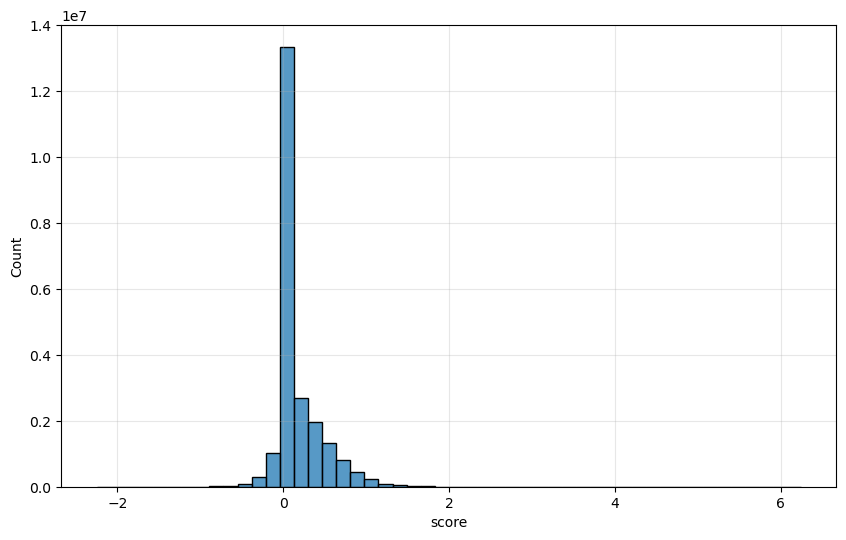

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=recommendations_df, x='score', bins=50)
plt.grid(True, alpha=0.3)
plt.show()

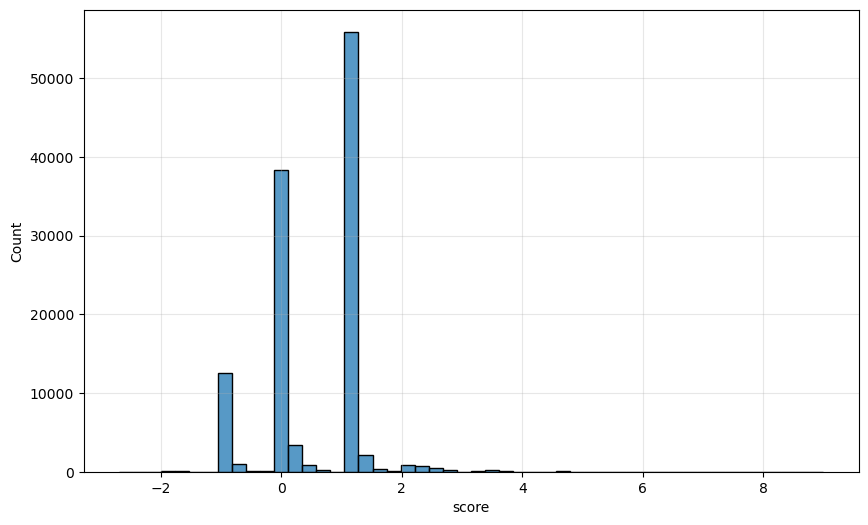

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=ground_truth_df, x='score', bins=50)
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
print(recommendations_df['score'])
print(ground_truth_df['score'])

0           6.879293e-01
1          -1.868840e-01
2           4.601102e-01
3           5.274569e-01
4           5.011785e-02
                ...     
22411995    5.394999e-43
22411996    2.424246e-43
22411997   -7.777206e-43
22411998   -9.949219e-44
22411999   -2.087935e-43
Name: score, Length: 22412000, dtype: float32
0         1.1
1         1.1
2        -0.9
3        -0.9
4         1.1
         ... 
118005   -0.9
118006    0.1
118007    0.1
118008    0.1
118009    1.1
Name: score, Length: 118010, dtype: float64
